In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import colors

import seaborn as sns
from scipy.stats import circvar

import skimage as skimage
import scipy as scipy
import scipy.ndimage
import cv2 as cv

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# %config InlineBackend.figure_format ='retina'

plt.rcParams.update({'font.size': 18})

In [3]:
Testing_Mode = False

########################################################################

filename = 'Test.tif'

########################################################################

heatmap_averaging_windows = 20

########################################################################

image_filter_sigma = 2

local_window_size = 10

Min_Coherance, Min_Orientation = 1e-4, 1e-4

########################################################################

spacing = 50 # Spacing between plotting the orientation vectors

scale = 40 # Length of each vector for plotting

### Read Image

In [4]:
def Test_Image():
    
    from skimage.draw import circle_perimeter_aa

    raw_image = np.zeros((600, 600)).astype(np.float32)

    rr, cc, val = circle_perimeter_aa(150, 150, 100)
    raw_image[rr, cc] = val

    rr, cc, val = circle_perimeter_aa(350, 300, 50)
    raw_image[rr, cc] = val

    raw_image = raw_image * 255
    
    return raw_image

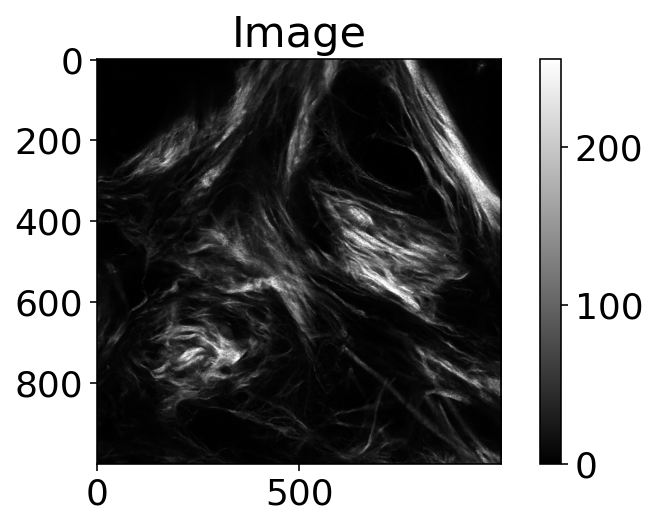

In [5]:
if Testing_Mode == False:
    
    filename_image = filename
    
    raw_image = skimage.io.imread(filename_image).astype('float32')

if Testing_Mode == True:

    raw_image = Test_Image()

########################################################################

plt.imshow(raw_image, cmap = 'gray')

plt.title('Image')

plt.colorbar()

# plt.xticks([])

# plt.yticks([])

plt.tight_layout()

plt.show()

### Create Image of same dimensions in X and Y

In [6]:
def make_image_same_shape(image):

    raw_image = np.zeros((max(image.shape), max(image.shape)))

    raw_image[:len(image)] = image
    
    return raw_image

### Create HeatMap

In [7]:
def make_HeatMap(input_image, number_heatmap_windows):

    # Define the local ROI

    local_region = skimage.morphology.rectangle(max(int(input_image.shape[0] / number_heatmap_windows), 1), 
                                                max(int(input_image.shape[0] / number_heatmap_windows), 1) )

    heatmap_image = skimage.filters.rank.mean(skimage.util.img_as_ubyte(input_image / input_image.max()), 
                                              footprint = local_region)

    return heatmap_image

### Make 2D Structure Tensor from Image

In [8]:
def make_StructureTensor2D(input_image, image_filter_sigma, local_window_size):

    ### Calculate image gradients using Sobel or Gaussian filters

    filtered_image = skimage.filters.gaussian(input_image, sigma = image_filter_sigma, 
                                              mode = 'nearest')

    image_gradient_x = scipy.ndimage.sobel(filtered_image, axis = 0, mode = 'nearest')

    image_gradient_y = scipy.ndimage.sobel(filtered_image, axis = 1, mode = 'nearest')
    
#     image_gradient_x = scipy.ndimage.gaussian_filter(raw_image, filter_sigma, order = [0, 1])

#     image_gradient_y = scipy.ndimage.gaussian_filter(raw_image, filter_sigma, order = [1, 0])

    #########################################################################################################

    ### Calculate Jxx, Jyy and Jxy

    Jxx = scipy.ndimage.gaussian_filter(image_gradient_x * image_gradient_x, local_window_size)

    Jyy = scipy.ndimage.gaussian_filter(image_gradient_y * image_gradient_y, local_window_size)

    Jxy = scipy.ndimage.gaussian_filter(image_gradient_x * image_gradient_y, local_window_size)
    
    #########################################################################################################

    ### Make Structure Tensor

    Raw_Structure_Tensor = np.array([[Jxx, Jxy], 
                                     [Jxy, Jyy]])

    Structure_Tensor = np.moveaxis(Raw_Structure_Tensor, [0, 1], [2, 3]) # For solving EigenProblem

    #########################################################################################################
    
    ### Calculate Energy

    Energy = np.trace(Raw_Structure_Tensor)

    #########################################################################################################
    
    return Structure_Tensor, Jxx, Jyy, Jxy, Energy

In [9]:
def solve_EigenProblem(Structure_Tensor):
    
    ## Solve EigenValue problem

    EigenValues, EigenVectors = np.linalg.eigh(Structure_Tensor)# eigh because matrix is symmetric

    #########################################################################################################

    return EigenValues, EigenVectors

### Calculate Orientation vector field, Orientation and Coherance

In [10]:
def make_Coherance_Orientation(input_image, EigenValues, EigenVectors, 
                               Structure_Tensor, Jxx, Jyy, Jxy, 
                               Min_Coherance, Min_Orientation):
    
    Coherance_Array = np.zeros(input_image.shape)
    
    vx = np.zeros(input_image.shape)
    
    vy = np.zeros(input_image.shape)

    ### Calculate Coherance and Orientation vector field

    Coherance_Array = np.zeros(input_image.shape)

    #############################################

    for j in range(input_image.shape[1]):

        for i in range(input_image.shape[0]):
            
            #############################################
            
            ### Calculate vector field of orientations

            vx[i, j] = EigenVectors[i, j][:, 0][0]

            vy[i, j] = EigenVectors[i, j][:, 0][1]

            #############################################
            
            ### Calculate Coherance

            if ( (EigenValues[i, j].sum()) > 0):

                Smallest_Normalized_Eigenvalues = EigenValues[i, j][0] / np.trace(Structure_Tensor[i, j])

                Largest_Normalized_Eigenvalues = EigenValues[i, j][1] / np.trace(Structure_Tensor[i, j])

                Coherance_Array[i, j] = np.abs((Smallest_Normalized_Eigenvalues - Largest_Normalized_Eigenvalues) /
                                               (Smallest_Normalized_Eigenvalues + Largest_Normalized_Eigenvalues))

            else:

                Coherance_Array[i, j] = 0

    ### Normalize Coherance between 0 and 1

    Coherance = cv.normalize(Coherance_Array, None, 
                             alpha = Min_Coherance, beta = 1, 
                             norm_type = cv.NORM_MINMAX, dtype = cv.CV_32F)

    #############################################
    
    ### Calculate Orientation

    Raw_Orientation_Array = 0.5 * ( cv.phase( (Jyy - Jxx), (2 * Jxy), angleInDegrees = True) )

    #############################################
    
    ### Normalize Orientation between 0 and 180

    Orientation = cv.normalize(Raw_Orientation_Array, None, 
                               alpha = Min_Orientation, beta = 180, 
                               norm_type = cv.NORM_MINMAX, dtype = cv.CV_32F)
    
#     ### Subtract 90 degrees when Orientation > 90 for easy visualization
    
#     Orientation[np.where(Orientation > 90)] -= 90
    
    #############################################
    
    return Coherance, Orientation, vx, vy

### Make discrete colormaps

In [11]:
def discrete_cmap(N, base_cmap):
    """Create an N-bin discrete colormap from the specified input map"""

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

### Start the procedure

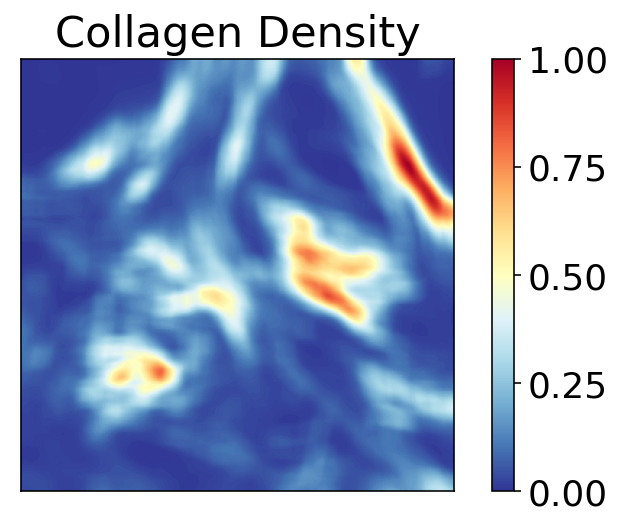

In [12]:
heatmap_image = make_HeatMap(raw_image, heatmap_averaging_windows)

plt.imshow(heatmap_image / heatmap_image.max(), 
           interpolation = 'nearest', vmin = 0, vmax = 1, 
           cmap = 'RdYlBu_r')

plt.colorbar(ticks = np.linspace(0, 1, 5))

plt.xticks([])

plt.yticks([])

plt.title('Collagen Density')

plt.tight_layout()

plt.show()

In [13]:
# Make Structure_Tensor

Structure_Tensor, Jxx, Jyy, Jxy, Energy = make_StructureTensor2D(raw_image, image_filter_sigma, local_window_size)

# Solve the EigenProblem

EigenValues, EigenVectors = solve_EigenProblem(Structure_Tensor)

# Calculate Orientation, Coherance

Coherance, Orientation, vx, vy = make_Coherance_Orientation(raw_image, EigenValues, EigenVectors,
                                                            Structure_Tensor, 
                                                            Jxx, Jyy, Jxy,
                                                            Min_Coherance, Min_Orientation)

### Plot Orientation and Coherance

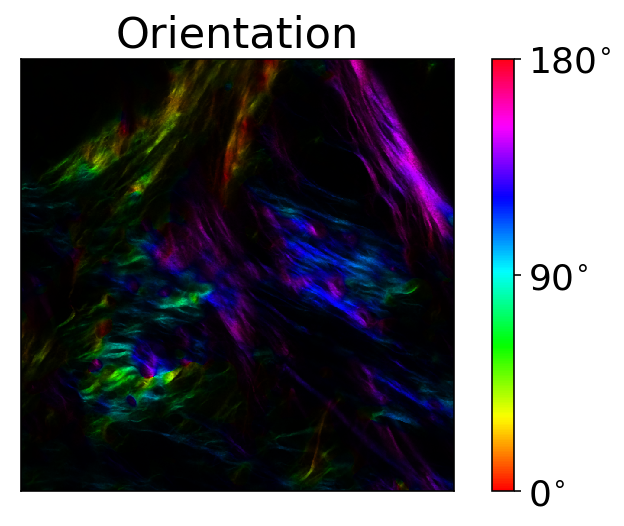

In [14]:
plt.imshow(plt.cm.gray(skimage.filters.median(raw_image/raw_image.max())) * plt.cm.hsv(Orientation/180),
           vmin = 0, vmax = 1,
           interpolation = 'nearest', cmap = 'hsv')

########################################################################

cbar = plt.colorbar(ticks = np.linspace(0, 1, 3))
cbar.ax.set_yticklabels([r'$0^{\circ}$', r'$90^{\circ}$', r'$180^{\circ}$'])

plt.title('Orientation')

plt.xticks([])

plt.yticks([])

plt.tight_layout()

plt.show()

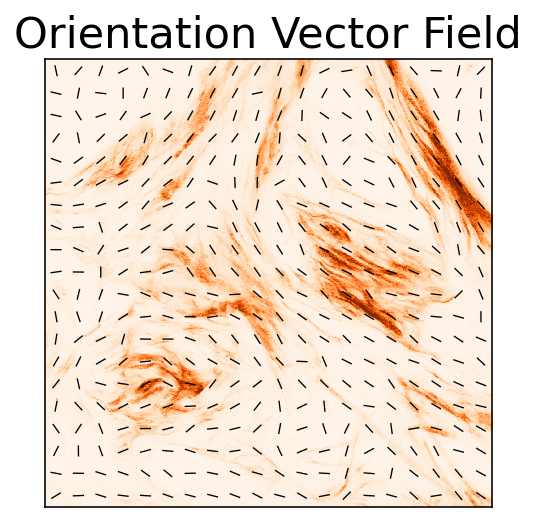

In [15]:
plt.imshow(raw_image, cmap = 'Oranges', interpolation = 'nearest', alpha = 1)

xmesh, ymesh = np.meshgrid(np.arange(raw_image.shape[0]), 
                           np.arange(raw_image.shape[1]), 
                           indexing = 'ij')

plt.quiver(ymesh[spacing//2::spacing, spacing//2::spacing], 
           xmesh[spacing//2::spacing, spacing//2::spacing],
           vy[spacing//2::spacing, spacing//2::spacing], 
           vx[spacing//2::spacing, spacing//2::spacing],
           scale = scale, headlength = 0, headaxislength = 0, 
           pivot = 'middle', color = 'k', angles = 'xy')

##################

plt.title('Orientation Vector Field')

plt.xticks([])

plt.yticks([])

plt.tight_layout()

plt.show()

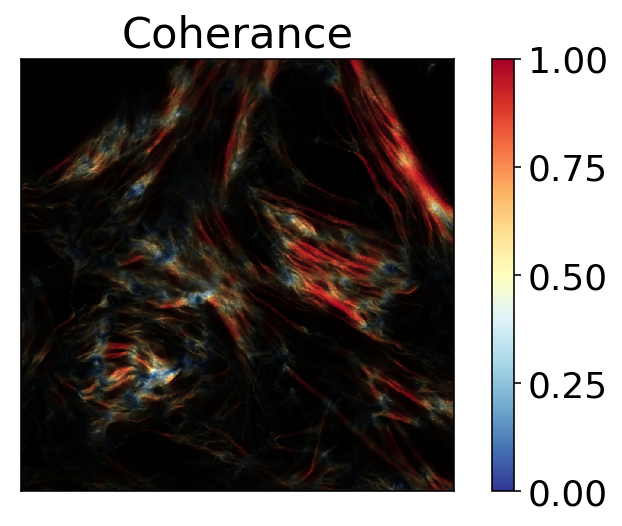

In [16]:
plt.imshow(plt.cm.gray(skimage.filters.median(raw_image/raw_image.max())) * plt.cm.RdYlBu_r(Coherance),
           interpolation = 'nearest', vmin = 0, vmax = 1, cmap = 'RdYlBu_r')

########################################################################

cbar = plt.colorbar(ticks = np.linspace(0, 1, 5))

plt.title('Coherance')

plt.xticks([])

plt.yticks([])

plt.tight_layout()

plt.show()

### Plot everything together

In [17]:
fig, ax = plt.subplots(1, 5, figsize = (50, 15), sharex = True, sharey = True)

ax[0].imshow(raw_image, cmap = 'binary_r')
ax[0].set_title('Image', pad = 20, fontsize = 40)
ax[0].set_xticks([])
ax[0].set_yticks([])
divider = make_axes_locatable(ax[0])
cax0 = divider.append_axes("right", size="5%", pad=0.4)
cax0.remove()

########################################################################

im1 = ax[1].imshow(plt.cm.gray(raw_image / raw_image.max()) * 
                   plt.cm.RdYlBu_r(heatmap_image / heatmap_image.max()), 
                   cmap = 'RdYlBu_r', vmin = 0, vmax = 1)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes("right", size="5%", pad=0.4)

cbar = fig.colorbar(im1, cax=cax1, ticks = np.linspace(0, 1, 5))
cbar.ax.set_yticklabels([r'$0$', r'$0.25$', r'$0.5$', r'$0.75$', r'$1$'], 
                        fontsize = 40)

ax[1].set_title('Collagen Density', pad = 20, fontsize = 40)
ax[1].set_xticks([])
ax[1].set_yticks([])

########################################################################

im2 = ax[2].imshow(plt.cm.gray(skimage.filters.median(raw_image / raw_image.max())) * 
                   plt.cm.RdYlBu_r(Coherance), 
                   vmin = 0, vmax = 1, cmap = 'RdYlBu_r')

divider = make_axes_locatable(ax[2])
cax2 = divider.append_axes("right", size="5%", pad=0.4)
cbar = fig.colorbar(im1, cax=cax2, ticks = np.linspace(0, 1, 5))
cbar.ax.set_yticklabels([r'$0$', r'$0.25$', r'$0.5$', r'$0.75$', r'$1$'], 
                        fontsize = 40)

ax[2].set_title('Coherance', pad = 20, fontsize = 40)
ax[2].set_xticks([])
ax[2].set_yticks([])

###########################################################data#############

im3 = ax[3].imshow(plt.cm.gray(skimage.filters.median(raw_image/raw_image.max())) * 
                   plt.cm.hsv(Orientation/180), 
                   vmin = 0, vmax = 1, cmap = 'hsv')

divider = make_axes_locatable(ax[3])
cax3 = divider.append_axes("right", size="5%", pad=0.4)

cbar = fig.colorbar(im3, cax=cax3, ticks = np.linspace(0, 1, 3))
cbar.ax.set_yticklabels([r'$0^{\circ}$', r'$90^{\circ}$', r'$180^{\circ}$'],
                        fontsize = 40)

ax[3].set_title('Orientation', pad = 20, fontsize = 40)
ax[3].set_xticks([])
ax[3].set_yticks([])

########################################################################

im4 = ax[4].imshow(skimage.filters.median(raw_image), cmap = 'binary_r', alpha = 1)

xmesh, ymesh = np.meshgrid(np.arange(raw_image.shape[0]), 
                           np.arange(raw_image.shape[1]), 
                           indexing = 'ij')

ax[4].quiver(ymesh[spacing//2::spacing, spacing//2::spacing], 
           xmesh[spacing//2::spacing, spacing//2::spacing],
           vy[spacing//2::spacing, spacing//2::spacing], 
           vx[spacing//2::spacing, spacing//2::spacing],
           scale = scale, headlength = 0, headaxislength = 0, 
           pivot = 'middle', color = 'yellow', angles = 'xy')

ax[4].set_title('Orientation Vector Field', pad = 20, fontsize = 40)
ax[4].set_xticks([])
ax[4].set_yticks([])

divider = make_axes_locatable(ax[4])
cax = divider.append_axes("right", size="5%", pad=0.4)
cax.remove()

########################################################################

fig.tight_layout()

plt.savefig('Analysis.pdf')

plt.close()

### Plot Orientation histogram

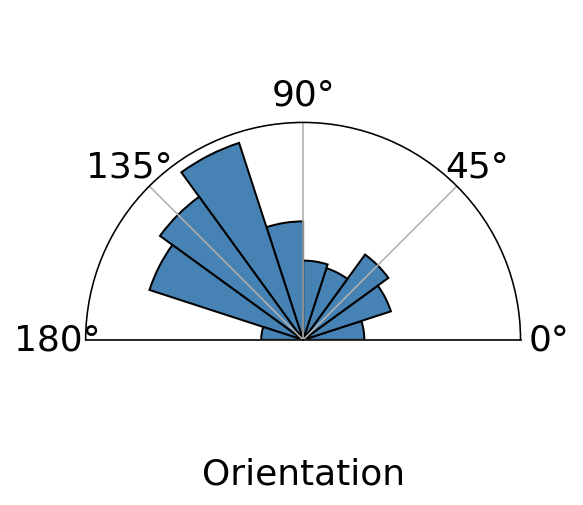

In [18]:
bin_size = int(180/10)

a , b = np.histogram(Orientation.ravel(), bins = np.arange(0, 180 + bin_size, bin_size), density = True)

centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])

fig = plt.figure()

ax = fig.add_subplot(111, projection = 'polar')

ax.bar(centers, a, width = np.deg2rad(bin_size), bottom = 0.0, color = 'steelblue', edgecolor = 'k')

ax.set_theta_zero_location("E")

ax.set_theta_direction(1)

ax.set_thetamin(0)

ax.set_thetamax(180)

ax.set_yticks([])

ax.set_xlabel('Orientation')

plt.show()

### Plot Coherance histogram

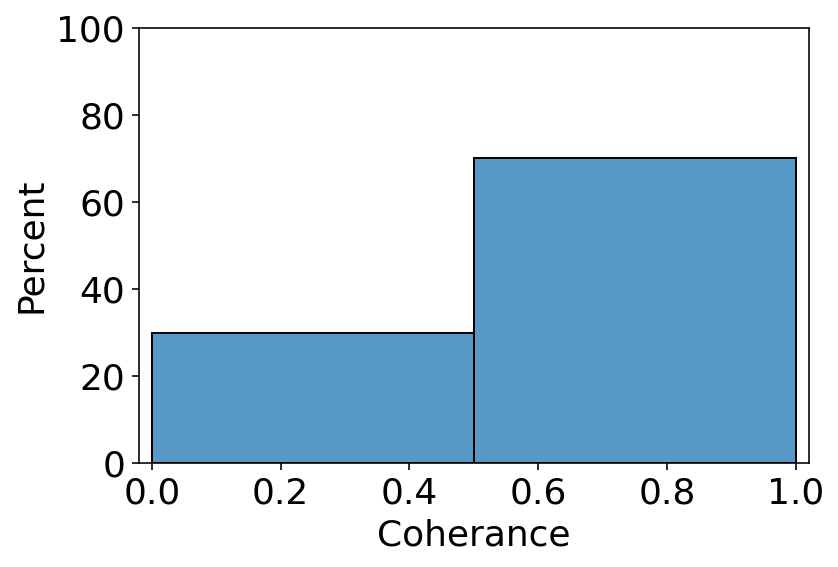

In [19]:
sns.histplot(Coherance.ravel(), bins = 2, stat = 'percent', fill = True)

plt.xlabel('Coherance')

plt.ylim(0, 100)

plt.xlim(-0.02, 1.02)

plt.show()

In [20]:
print()

print(np.mean(Orientation), np.std(Orientation), np.mean(Coherance), np.std(Coherance))

print()


98.86951 46.125824 0.6142452 0.23436469

